In [1]:
import os
from torch.utils.data import Dataset, DataLoader
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
from torchvision import datasets, models, transforms

In [3]:
class TomatoDataset(Dataset):
    """Dataset Томатов"""
    
    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir
        self.list_classes = list(sorted(os.listdir(root_dir)))
        self.img_path_list = []
        for one_class in self.list_classes:
            count_img = list(os.listdir(os.path.join(root_dir,
                                                     one_class)))
            for img in count_img:
                self.img_path_list.append(os.path.join(one_class,img))
        self.transform = transform
        self.img_list = np.empty([len(self.img_path_list), 256, 256, 3], dtype=np.uint8)
        for i, path in enumerate(self.img_path_list):
            self.img_list[i] = self.__get_img_by_path(os.path.join(root_dir, path))   
            
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        target = self.list_classes.index(os.path.dirname(self.img_path_list[index]))
        sample = {'image': self.img_list[index], 'target': target}
    
        if self.transform:
            sample["image"] = self.transform(self.img_list[index])
    
        return sample
    
    def __get_img_by_path(self, img_path):
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = np.array(img)
        return img

In [4]:
data = TomatoDataset("DataSet/train",transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.RandomResizedCrop(244),
                                    transforms.RandomHorizontalFlip(),
#                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#                                    Rescale(324),
                                  ]),)

In [43]:
data[0]['image'].to(torch.float16)

tensor([[[0.5962, 0.5962, 0.5962,  ..., 0.5854, 0.5898, 0.5923],
         [0.5996, 0.5996, 0.5996,  ..., 0.5854, 0.5898, 0.5923],
         [0.6040, 0.6040, 0.6040,  ..., 0.5850, 0.5894, 0.5918],
         ...,
         [0.4661, 0.4666, 0.4673,  ..., 0.1637, 0.1511, 0.1438],
         [0.5073, 0.4954, 0.4746,  ..., 0.1639, 0.1697, 0.1729],
         [0.5371, 0.5166, 0.4805,  ..., 0.1660, 0.1851, 0.1960]],

        [[0.5728, 0.5728, 0.5728,  ..., 0.5620, 0.5664, 0.5688],
         [0.5757, 0.5757, 0.5757,  ..., 0.5620, 0.5664, 0.5688],
         [0.5806, 0.5806, 0.5806,  ..., 0.5615, 0.5659, 0.5684],
         ...,
         [0.4424, 0.4429, 0.4438,  ..., 0.2423, 0.2296, 0.2224],
         [0.4839, 0.4719, 0.4512,  ..., 0.2424, 0.2480, 0.2512],
         [0.5137, 0.4929, 0.4568,  ..., 0.2444, 0.2634, 0.2744]],

        [[0.5806, 0.5806, 0.5806,  ..., 0.5620, 0.5664, 0.5688],
         [0.5835, 0.5835, 0.5835,  ..., 0.5620, 0.5664, 0.5688],
         [0.5884, 0.5884, 0.5884,  ..., 0.5615, 0.5659, 0.

In [5]:
def show_data(df):   
    fig = plt.figure(figsize=(13,13))


    for i in range(0,len(df),2000):
        sample = df[i]

        print(i, sample['image'].shape, sample['target'])
        i = int(i/2000)
        ax = plt.subplot(1, 4, i + 1)
        plt.tight_layout()
        ax.set_title('Sample {}'.format(i))
        ax.axis('off')
        plt.imshow(sample['image'].numpy().transpose((1, 2, 0)))
        if i == 3:
            plt.show()
            break


0 torch.Size([3, 244, 244]) 0
2000 torch.Size([3, 244, 244]) 1
4000 torch.Size([3, 244, 244]) 2
6000 torch.Size([3, 244, 244]) 3


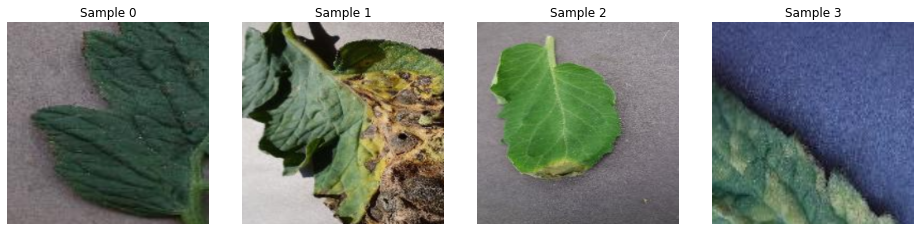

In [6]:
show_data(data)

In [7]:
valid = TomatoDataset("DataSet/valid", transform = transforms.Compose([transforms.ToTensor(),
        transforms.Resize(256),
        transforms.CenterCrop(244),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                                                      ]))

0 torch.Size([3, 244, 244]) 0
2000 torch.Size([3, 244, 244]) 4
4000 torch.Size([3, 244, 244]) 8


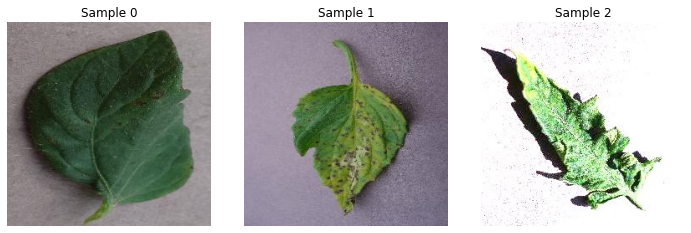

In [8]:
show_data(valid)

In [9]:
len(data)

18345

In [10]:
len(valid)

4585

In [11]:
data.list_classes

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [9]:
output_mapping = {
    0: 'Tomato___Bacterial_spot',
    1: 'Tomato___Early_blight',
    2: 'Tomato___Late_blight',
    3: 'Tomato___Leaf_Mold',
    4: 'Tomato___Septoria_leaf_spot',
    5: 'Tomato___Spider_mites Two-spotted_spider_mite',
    6: 'Tomato___Target_Spot',
    7: 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
    8: 'Tomato___Tomato_mosaic_virus',
    9: 'Tomato___healthy'
}

In [62]:
from collections import Counter
cnt_train = Counter([data[i]['target']for i in range(0,len(data))])

In [63]:
cnt_train

Counter({0: 1702,
         1: 1920,
         2: 1851,
         3: 1882,
         4: 1745,
         5: 1741,
         6: 1827,
         7: 1961,
         8: 1790,
         9: 1926})

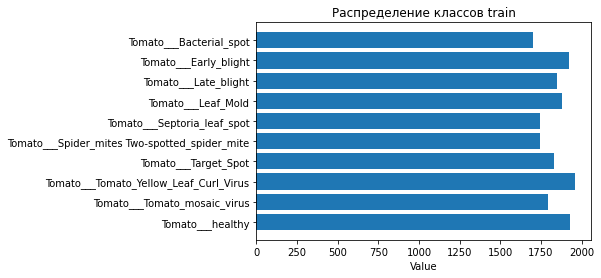

In [88]:
fig, ax = plt.subplots()
label = [output_mapping[j] for j in range(0,10)]
value = [cnt_train[j] for j in range(0,10)]
ax.barh(label, value, align='center')
ax.invert_yaxis()
# plt.bar(label, value)
# plt.xticks(rotation=90)
ax.set_xlabel('Value')
ax.set_title('Распределение классов train')
plt.show()

In [64]:
cnt_valid = Counter([valid[i]['target']for i in range(0,len(valid))])
cnt_valid

Counter({0: 425,
         1: 480,
         2: 463,
         3: 470,
         4: 436,
         5: 435,
         6: 457,
         7: 490,
         8: 448,
         9: 481})

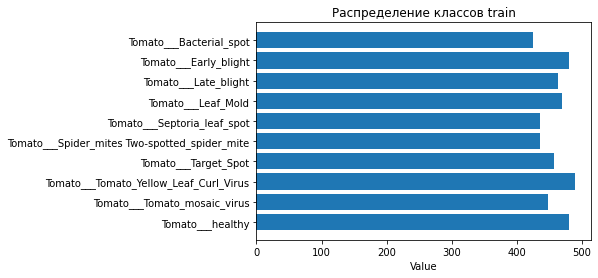

In [90]:
fig, ax = plt.subplots()
label = [output_mapping[j] for j in range(0,10)]
value = [cnt_valid[j] for j in range(0,10)]
ax.barh(label, value, align='center')
ax.invert_yaxis()
# plt.bar(label, value)
# plt.xticks(rotation=90)
ax.set_xlabel('Value')
ax.set_title('Распределение классов train')
plt.show()

In [10]:
train_dataloader = DataLoader(data, batch_size=6, shuffle=True)
valid_dataloader = DataLoader(valid, batch_size=6, shuffle=True)

In [11]:
image_datasets = {'train':data,
                  'val':valid}
dataloaders = {'train':train_dataloader,
               'val':valid_dataloader}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = output_mapping

In [15]:
use_gpu = torch.cuda.is_available()

In [19]:
from torch.cuda import amp
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    #Ваш код здесь
    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
               
                model.train(True)  # установаить модель в режим обучения
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                # получаем картинки и метки
                inputs = data['image'].to(torch.float16)
                labels = data['target']

                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                with amp.autocast(enabled=use_gpu):
                    if phase == "eval":
                        with torch.no_grad():
                            outputs = model(inputs)
                    else:
                        outputs = model(inputs)
                
                    preds = torch.argmax(outputs, -1)
                    loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    scheduler.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            # Ваш код здесь
            losses[phase].append(epoch_loss)
            
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

In [14]:
import torch.nn as nn

In [13]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from tqdm.autonotebook import tqdm, trange

In [19]:
model_extractor

NameError: name 'model_extractor' is not defined

In [ ]:
# Ваш код здесь
model_extractor = models.vgg16(pretrained=True)

# замораживаем параметры (веса)
for param in model_extractor.features.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, 10)

# Использовать ли GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [80]:
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/1147 [00:00<?, ?it/s]

val iter::   0%|          | 0/287 [00:00<?, ?it/s]

train iter::   0%|          | 0/1147 [00:00<?, ?it/s]

val iter::   0%|          | 0/287 [00:00<?, ?it/s]

train iter::   0%|          | 0/1147 [00:00<?, ?it/s]

val iter::   0%|          | 0/287 [00:00<?, ?it/s]

train iter::   0%|          | 0/1147 [00:00<?, ?it/s]

val iter::   0%|          | 0/287 [00:00<?, ?it/s]

train iter::   0%|          | 0/1147 [00:00<?, ?it/s]

val iter::   0%|          | 0/287 [00:00<?, ?it/s]

train iter::   0%|          | 0/1147 [00:00<?, ?it/s]

val iter::   0%|          | 0/287 [00:00<?, ?it/s]

train iter::   0%|          | 0/1147 [00:00<?, ?it/s]

val iter::   0%|          | 0/287 [00:00<?, ?it/s]

train iter::   0%|          | 0/1147 [00:00<?, ?it/s]

val iter::   0%|          | 0/287 [00:00<?, ?it/s]

train iter::   0%|          | 0/1147 [00:00<?, ?it/s]

val iter::   0%|          | 0/287 [00:00<?, ?it/s]

train iter::   0%|          | 0/1147 [00:00<?, ?it/s]

val iter::   0%|          | 0/287 [00:00<?, ?it/s]

Training complete in 65m 47s
Best val Acc: 0.695311


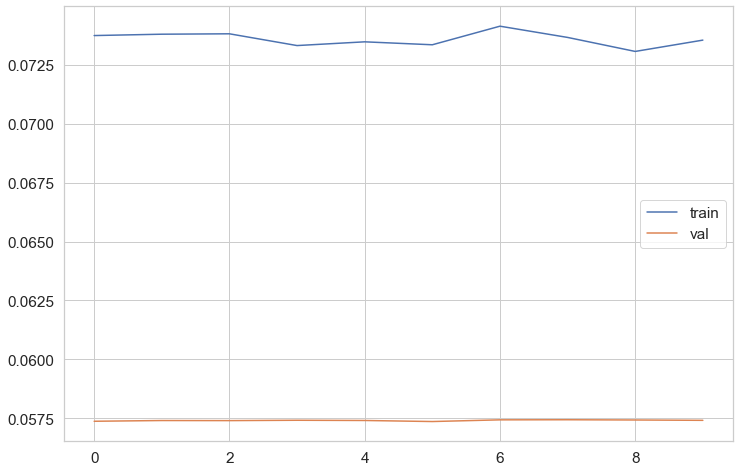

In [86]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [ ]:
torch.save(model_extractor.state_dict(), 'VGG16.pth')

In [17]:
# Ваш код здесь
model_mixed = models.vgg16(pretrained=True)

layers_to_unfreeze = 5

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_mixed.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
    
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_mixed.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=num_features, out_features=1024, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=1024, out_features=10, bias=True),
  )

# Использовать ли GPU
if use_gpu:
    model_mixed = model_mixed.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой 
# parameters() возвращает просто список тензоров парамтеров, поэтому два таких списка можно сложить
optimizer = optim.Adam(list(model_mixed.features.parameters())[-layers_to_unfreeze:] + 
                      list(model_mixed.classifier.parameters()), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [20]:
model_mixed, losses_mixed = train_model(model_mixed, loss_fn, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

val iter::   0%|          | 0/765 [00:00<?, ?it/s]

train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

val iter::   0%|          | 0/765 [00:00<?, ?it/s]

train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

val iter::   0%|          | 0/765 [00:00<?, ?it/s]

train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

val iter::   0%|          | 0/765 [00:00<?, ?it/s]

train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

val iter::   0%|          | 0/765 [00:00<?, ?it/s]

train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

val iter::   0%|          | 0/765 [00:00<?, ?it/s]

train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

val iter::   0%|          | 0/765 [00:00<?, ?it/s]

train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

val iter::   0%|          | 0/765 [00:00<?, ?it/s]

train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

val iter::   0%|          | 0/765 [00:00<?, ?it/s]

train iter::   0%|          | 0/3058 [00:00<?, ?it/s]

val iter::   0%|          | 0/765 [00:00<?, ?it/s]

Training complete in 264m 10s
Best val Acc: 0.092694
